In [ ]:
# 1: Install required dependencies
# --------------------------------------------------------
!pip install datasets kaggle huggingface_hub pandas nltk beautifulsoup4 requests matplotlib seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00


In [ ]:
# 2: Import required libraries and create directories
# --------------------------------------------------------
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
from bs4 import BeautifulSoup
import nltk
import warnings
warnings.filterwarnings('ignore')

# Create output directories
os.makedirs('./data', exist_ok=True)
os.makedirs('./output', exist_ok=True)

print("Libraries imported and directories created successfully!")

Libraries imported and directories created successfully!


In [ ]:
# 3: Download NLTK resources
# --------------------------------------------------------
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual WordNet

print("NLTK resources downloaded successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


NLTK resources downloaded successfully!


In [ ]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username":"charishmatamarana","key":"589c986844903c7219f51ac527dc695b"}, f)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 5: Define preprocessing functions
# --------------------------------------------------------
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import re

def preprocess_text(text):
    """Comprehensive text preprocessing with all required steps"""
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 4. Handle negations (don't, won't, etc.)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'d", " would", text)

    # 5. Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # 6. Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # 7. Tokenization (with fallback to simple split)
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()

    # 8. Remove stopwords
    try:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    except:
        pass  # Continue without stopword removal if it fails

    # 9. Stemming
    try:
        stemmer = PorterStemmer()
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
    except:
        stemmed_tokens = tokens

    # 10. Lemmatization
    try:
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    except:
        lemmatized_tokens = tokens

    # We'll use lemmatized tokens for final output
    final_tokens = lemmatized_tokens

    # 11. Join tokens back to string
    processed_text = ' '.join(final_tokens)

    # 12. Remove extra spaces
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text

def preprocess_code(text):
    """Preprocessing for code segments to preserve syntax and structure"""
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # 1. Remove URLs and HTML
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # 2. Normalize whitespace (but keep indentation structure)
    text = re.sub(r'\t', '    ', text)  # Convert tabs to spaces
    text = re.sub(r' +\n', '\n', text)  # Remove trailing spaces

    # 3. Remove excess blank lines
    text = re.sub(r'\n{3,}', '\n\n', text)

    return text.strip()

def contains_code(text):
    """Check if text likely contains code"""
    if pd.isna(text) or not isinstance(text, str):
        return False

    code_indicators = [
        r'def\s+\w+\s*\(', r'class\s+\w+', r'import\s+\w+',
        r'for\s+\w+\s+in\s+', r'while\s+\w+', r'if\s+\w+\s*:',
        r'=\s*\w+\(', r'return\s+\w+', r'print\s*\(',
        r'lambda\s+\w+\s*:', r'\.append\(', r'\.iloc\[', r'\.loc\[',
        r'pd\.', r'np\.', r'plt\.', r'fig,\s*ax', r'=\s*pd\.read_'
    ]

    for pattern in code_indicators:
        if re.search(pattern, text):
            return True

    # Check for Excel formula indicators
    excel_indicators = [
        r'=SUM\(', r'=AVERAGE\(', r'=COUNT\(', r'=IF\(',
        r'=VLOOKUP\(', r'=INDEX\(', r'=MATCH\(',
        r'=CONCATENATE\(', r'=MID\(', r'=LEFT\(', r'=RIGHT\('
    ]

    for pattern in excel_indicators:
        if re.search(pattern, text, re.IGNORECASE):
            return True

    return False

def smart_preprocess(text):
    """Apply appropriate preprocessing based on content"""
    has_code = contains_code(text)

    result = {
        'text': preprocess_text(text),
        'contains_code': has_code
    }

    if has_code:
        result['code'] = preprocess_code(text)

    return result

# Test the preprocessing functions with samples
text_sample = "Here's an explanation about Python functions and their usage in data analysis."
code_sample = "def calculate_sum(a, b):\n    # This adds two numbers\n    return a + b\n\nresult = calculate_sum(5, 10)"
excel_sample = "To calculate the sum in Excel, use =SUM(A1:A10) function."

# Test text-only sample
text_result = smart_preprocess(text_sample)
print(f"Original text: {text_sample}")
print(f"Processed text: {text_result['text']}")
print(f"Contains code: {text_result['contains_code']}")
print()

# Test code sample
code_result = smart_preprocess(code_sample)
print(f"Original code: {code_sample}")
print(f"Processed text: {code_result['text']}")
print(f"Processed code: {code_result['code']}")
print(f"Contains code: {code_result['contains_code']}")
print()

# Test Excel formula sample
excel_result = smart_preprocess(excel_sample)
print(f"Original Excel: {excel_sample}")
print(f"Processed text: {excel_result['text']}")
print(f"Contains code: {excel_result['contains_code']}")
if 'code' in excel_result:
    print(f"Processed code: {excel_result['code']}")

Original text: Here's an explanation about Python functions and their usage in data analysis.
Processed text: explanation python function usage data analysis
Contains code: False

Original code: def calculate_sum(a, b):
    # This adds two numbers
    return a + b

result = calculate_sum(5, 10)
Processed text: def calculate_sum b add two number return b result calculate_sum
Processed code: def calculate_sum(a, b):
    # This adds two numbers
    return a + b

result = calculate_sum(5, 10)
Contains code: True

Original Excel: To calculate the sum in Excel, use =SUM(A1:A10) function.
Processed text: calculate sum excel use sum function
Contains code: True
Processed code: To calculate the sum in Excel, use =SUM(A1:A10) function.


In [ ]:
# 6: Define Data Sources
# --------------------------------------------------------
data_sources = [
    # Python Q&A sources
    {
        "name": "BAAI/TACO",
        "type": "huggingface",
        "domain": "Python",
        "url": "BAAI/TACO",
        "column_mapping": {"instruction": "question", "response": "answer"}
    },
    {
        "name": "Stack Overflow Python",
        "type": "huggingface",
        "domain": "Python",
        "url": "bond0213/Python-Questions-from-Stack-Overflow-dataset",
        "column_mapping": {"title": "question", "answer": "answer"}
    },
    {
        "name": "Python Programming Questions",
        "type": "kaggle",
        "domain": "Python",
        "url": "bhaveshmittal/python-programming-questions-dataset",
        "column_mapping": {"question": "question", "answer": "answer"}
    },
    # Python MCQ sources
    {
        "name": "Python MCQs",
        "type": "web",
        "domain": "Python MCQ",
        "url": "https://www.sanfoundry.com/python-questions-answers/",
        "selectors": {
            "question": ".entry-content p strong",
            "answer": ".entry-content p ~ div"
        }
    },

    # Python Programming Exercises
    {
        "name": "Python Exercises",
        "type": "web",
        "domain": "Python Exercises",
        "url": "https://www.w3resource.com/python-exercises/",
        "selectors": {
            "question": ".exercise-content h3",
            "answer": ".exercise-content pre"
        }
    },

    # Excel Q&A sources
    {
        "name": "Excel Interview Questions",
        "type": "web",
        "domain": "Excel",
        "url": "https://www.interviewbit.com/excel-interview-questions/",
        "selectors": {
            "question": ".question-content h3",
            "answer": ".question-content h3 ~ p, .question-content h3 ~ ul"
        }
    },
    {
        "name": "TPointTech Excel",
        "type": "web",
        "domain": "Excel",
        "url": "https://www.tpointtech.com/excel-interview-questions",
        "selectors": {
            "question": "h3",
            "answer": "h3 + p, h3 + ul, h3 + ol"
        }
    },
    {
        "name": "Trump Excel",
        "type": "web",
        "domain": "Excel",
        "url": "https://trumpexcel.com/excel-interview-questions/",
        "selectors": {
            "question": "h2, h3",
            "answer": "h2 + p, h3 + p, h2 + ul, h3 + ul"
        }
    },
    {
        "name": "Edureka Excel",
        "type": "web",
        "domain": "Excel",
        "url": "https://www.edureka.co/blog/interview-questions/excel-interview-questions/",
        "selectors": {
            "question": "h3",
            "answer": "h3 + p, h3 + ul, h3 + ol"
        }
    }
]

print(f"Defined {len(data_sources)} data sources:")
print(f"- Python sources: {len([s for s in data_sources if 'Python' in s['domain']])}")
print(f"- Excel sources: {len([s for s in data_sources if 'Excel' in s['domain']])}")

Defined 9 data sources:
- Python sources: 5
- Excel sources: 4


In [ ]:
# 7: Load Hugging Face Datasets
# --------------------------------------------------------
from datasets import load_dataset  # Add this import at the top

def load_huggingface_datasets(sources):
    """Load datasets from Hugging Face with error handling"""
    datasets_list = []
    hf_sources = [source for source in sources if source['type'] == 'huggingface']
    print(f"Loading {len(hf_sources)} Hugging Face datasets...")

    for source in hf_sources:
        try:
            print(f"\nLoading {source['name']} dataset...")
            # Load the dataset
            dataset = load_dataset(source['url'], split="train", trust_remote_code=True)
            print(f"Column names: {list(dataset.features.keys())}")

            # Convert to DataFrame
            raw_df = pd.DataFrame(dataset)

            # Dataset-specific handling
            if source['name'] == "BAAI/TACO":
                if 'question' in raw_df.columns and 'solutions' in raw_df.columns:
                    # Extract first solution if it's a list
                    raw_df['answer'] = raw_df['solutions'].apply(
                        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else str(x)
                    )
                    raw_df = raw_df[['question', 'answer']]
                    print(f"Mapped TACO dataset using 'question' and 'solutions' columns")

            elif source['name'] == "Stack Overflow Python":
                if 'instruction' in raw_df.columns and 'output' in raw_df.columns:
                    raw_df['question'] = raw_df['instruction']
                    raw_df['answer'] = raw_df['output']
                    raw_df = raw_df[['question', 'answer']]
                    print(f"Mapped Stack Overflow dataset using 'instruction' and 'output' columns")
                elif 'title' in raw_df.columns and 'answer' in raw_df.columns:
                    raw_df['question'] = raw_df['title']
                    raw_df = raw_df[['question', 'answer']]
                    print(f"Mapped Stack Overflow dataset using 'title' and 'answer' columns")
                elif 'question' in raw_df.columns and 'best_answer' in raw_df.columns:
                    raw_df['answer'] = raw_df['best_answer']
                    raw_df = raw_df[['question', 'answer']]
                    print(f"Mapped Stack Overflow dataset using 'question' and 'best_answer' columns")

            # Apply generic column mapping for other datasets
            else:
                column_mapping = source.get('column_mapping', {})
                if column_mapping:
                    valid_mapping = {k: v for k, v in column_mapping.items() if k in raw_df.columns}
                    if valid_mapping:
                        raw_df = raw_df.rename(columns=valid_mapping)

            # Make sure we have question and answer columns
            if 'question' in raw_df.columns and 'answer' in raw_df.columns:
                raw_df = raw_df[['question', 'answer']]
            else:
                print(f"Warning: Expected columns not found in {source['name']} after mapping.")
                # Print available columns to help with debugging
                print(f"Available columns: {list(raw_df.columns)}")

                # Try to intelligently identify question and answer columns
                potential_question_cols = [col for col in raw_df.columns if any(
                    q_term in col.lower() for q_term in ['question', 'title', 'problem', 'instruction', 'query']
                )]

                potential_answer_cols = [col for col in raw_df.columns if any(
                    a_term in col.lower() for a_term in ['answer', 'solution', 'response', 'output', 'result']
                )]

                # If we found promising columns, use them
                if potential_question_cols and potential_answer_cols:
                    q_col = potential_question_cols[0]
                    a_col = potential_answer_cols[0]
                    print(f"Auto-detected columns: {q_col} (question) and {a_col} (answer)")
                    raw_df = raw_df[[q_col, a_col]].copy()
                    raw_df.columns = ['question', 'answer']
                # Otherwise fall back to first two text columns
                else:
                    text_cols = raw_df.select_dtypes(include=['object']).columns
                    if len(text_cols) >= 2:
                        # Show samples of the first few columns
                        print("Column content samples:")
                        for col in text_cols[:3]:
                            sample = str(raw_df[col].iloc[0])
                            print(f"  {col}: {sample[:100]}..." if len(sample) > 100 else f"  {col}: {sample}")

                        # Use first two text columns
                        raw_df = raw_df[text_cols[:2]].copy()
                        raw_df.columns = ['question', 'answer']
                        print(f"Using {text_cols[0]} as question and {text_cols[1]} as answer")
                    else:
                        print(f"Skipping {source['name']} - incompatible structure")
                        continue

            # Add metadata
            raw_df['source'] = source['name']
            raw_df['domain'] = source['domain']
            raw_df['type'] = 'QA'  # Default type

            # Clean up data - remove rows with missing values
            raw_df = raw_df.dropna(subset=['question', 'answer'])

            # Remove very short questions/answers
            raw_df = raw_df[(raw_df['question'].str.len() > 10) & (raw_df['answer'].str.len() > 10)]

            # Sample data for verification
            if len(raw_df) > 0:
                print("\nSample data from processed dataset:")
                print(f"Question: {raw_df['question'].iloc[0][:100]}..." if len(raw_df['question'].iloc[0]) > 100 else f"Question: {raw_df['question'].iloc[0]}")
                print(f"Answer: {raw_df['answer'].iloc[0][:100]}..." if len(raw_df['answer'].iloc[0]) > 100 else f"Answer: {raw_df['answer'].iloc[0]}")

            # Add to collection
            datasets_list.append(raw_df)
            print(f"Added {len(raw_df)} entries from {source['name']}")

        except Exception as e:
            print(f"Error loading {source['name']}: {e}")
            import traceback
            traceback.print_exc()

    return datasets_list

huggingface_datasets = load_huggingface_datasets(data_sources)

Loading 2 Hugging Face datasets...

Loading BAAI/TACO dataset...


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

TACO.py:   0%|          | 0.00/6.00k [00:00<?, ?B/s]

data-00000-of-00009.arrow:   0%|          | 0.00/530M [00:00<?, ?B/s]

data-00001-of-00009.arrow:   0%|          | 0.00/613M [00:00<?, ?B/s]

data-00002-of-00009.arrow:   0%|          | 0.00/335M [00:00<?, ?B/s]

data-00003-of-00009.arrow:   0%|          | 0.00/403M [00:00<?, ?B/s]

data-00004-of-00009.arrow:   0%|          | 0.00/417M [00:00<?, ?B/s]

data-00005-of-00009.arrow:   0%|          | 0.00/503M [00:00<?, ?B/s]

data-00006-of-00009.arrow:   0%|          | 0.00/447M [00:00<?, ?B/s]

data-00007-of-00009.arrow:   0%|          | 0.00/526M [00:00<?, ?B/s]

data-00008-of-00009.arrow:   0%|          | 0.00/466M [00:00<?, ?B/s]

data-00000-of-00001.arrow:   0%|          | 0.00/496M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25443 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Column names: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity']
Mapped TACO dataset using 'question' and 'solutions' columns

Sample data from processed dataset:
Question: There are $n$ candy boxes in front of Tania. The boxes are arranged in a row from left to right, num...
Answer: ["INF = 10000000000.0\nmax_n = 50\nmax_k = 2000\n\ndef main():\n\t(n, s, k) = map(int, input().split...
Added 19493 entries from BAAI/TACO

Loading Stack Overflow Python dataset...


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

(…)estions_from_Stack_Overflow_dataset.json:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18568 [00:00<?, ? examples/s]

Column names: ['instruction', 'input', 'output']
Mapped Stack Overflow dataset using 'instruction' and 'output' columns

Sample data from processed dataset:
Question: How can I find the full path to a font from its display name on a Mac?
Answer: Unfortunately the only API that isn't deprecated is located in the ApplicationServices framework, wh...
Added 18568 entries from Stack Overflow Python


In [ ]:
# 8: Load Kaggle Datasets
# --------------------------------------------------------
def load_kaggle_datasets(sources):
    """Download and load datasets from Kaggle with error handling"""
    datasets_list = []
    kaggle_sources = [source for source in sources if source['type'] == 'kaggle']
    print(f"Loading {len(kaggle_sources)} Kaggle datasets...")

    for source in kaggle_sources:
        try:
            print(f"\nProcessing {source['name']}...")
            # Ensure data directory exists
            os.makedirs('./data', exist_ok=True)

            # Try to download dataset
            try:
                print(f"Attempting to download from Kaggle...")
                !kaggle datasets download -d {source['url']} --unzip -p ./data
                print("Download successful")
            except Exception as download_error:
                print(f"Download failed: {download_error}")
                continue

            # Find all CSV files
            import glob
            csv_files = glob.glob('./data/*.csv')
            print(f"Found {len(csv_files)} CSV files")

            # Process each CSV file
            for csv_file in csv_files:
                try:
                    # Try different encodings
                    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']:
                        try:
                            raw_df = pd.read_csv(csv_file, encoding=encoding)
                            print(f"Successfully loaded {csv_file} with {encoding} encoding")
                            print(f"Column names: {list(raw_df.columns)}")

                            # Apply column mapping if available
                            column_mapping = source.get('column_mapping', {})
                            if column_mapping:
                                valid_mapping = {k: v for k, v in column_mapping.items() if k in raw_df.columns}
                                if valid_mapping:
                                    raw_df = raw_df.rename(columns=valid_mapping)
                                    print(f"Applied column mapping: {valid_mapping}")

                            # Try to find question and answer columns - more inclusive approach
                            q_candidates = ['question', 'problem', 'title', 'instruction', 'query']
                            a_candidates = ['answer', 'solution', 'response', 'output', 'result']

                            # Try exact match first (case-insensitive)
                            q_col = next((col for col in raw_df.columns if col.lower() in q_candidates), None)
                            a_col = next((col for col in raw_df.columns if col.lower() in a_candidates), None)

                            # If not found, try partial match
                            if not q_col:
                                q_col = next((col for col in raw_df.columns if any(q in col.lower() for q in q_candidates)), None)
                            if not a_col:
                                a_col = next((col for col in raw_df.columns if any(a in col.lower() for a in a_candidates)), None)

                            # Special case for Python Programming Questions Dataset
                            if csv_file.endswith("Python Programming Questions Dataset.csv") and "Instruction" in raw_df.columns:
                                q_col = "Instruction"
                                a_col = "Output"
                                print(f"Special handling for Python Programming Questions Dataset")

                            # If still not found and we have at least 2 columns, use first two
                            if (not q_col or not a_col) and len(raw_df.columns) >= 2:
                                # Print first row of each column to help debug
                                print("First row content:")
                                for col in raw_df.columns[:3]:  # First 3 columns
                                    val = str(raw_df[col].iloc[0])
                                    sample = val[:100] + "..." if len(val) > 100 else val
                                    print(f"  {col}: {sample}")

                                # Use first two columns as fallback
                                if not q_col and not a_col:
                                    q_col = raw_df.columns[0]
                                    a_col = raw_df.columns[1]
                                    print(f"Falling back to first two columns: {q_col} as question, {a_col} as answer")
                                elif not q_col:
                                    # Find a column different from a_col
                                    q_col = next(col for col in raw_df.columns if col != a_col)
                                elif not a_col:
                                    # Find a column different from q_col
                                    a_col = next(col for col in raw_df.columns if col != q_col)

                            if q_col and a_col:
                                print(f"Found question column: {q_col}, answer column: {a_col}")
                                processed_df = raw_df[[q_col, a_col]].copy()
                                processed_df.columns = ['question', 'answer']

                                # Clean up data
                                processed_df = processed_df.dropna()
                                processed_df = processed_df[(processed_df['question'].astype(str).str.len() > 10) &
                                                          (processed_df['answer'].astype(str).str.len() > 10)]

                                if len(processed_df) > 0:
                                    # Sample data for verification
                                    print("\nSample data from processed dataset:")
                                    print(f"Question: {processed_df['question'].iloc[0][:100]}..." if len(str(processed_df['question'].iloc[0])) > 100 else f"Question: {processed_df['question'].iloc[0]}")
                                    print(f"Answer: {processed_df['answer'].iloc[0][:100]}..." if len(str(processed_df['answer'].iloc[0])) > 100 else f"Answer: {processed_df['answer'].iloc[0]}")

                                    processed_df['source'] = source['name']
                                    processed_df['domain'] = source['domain']
                                    processed_df['type'] = 'QA'  # Default type
                                    datasets_list.append(processed_df)
                                    print(f"Added {len(processed_df)} entries from {source['name']}")
                                    break
                                else:
                                    print(f"No valid entries after filtering in {csv_file}")
                            else:
                                print(f"Couldn't identify question and answer columns in {csv_file}")
                        except Exception as enc_error:
                            print(f"Could not load {csv_file} with {encoding} encoding: {enc_error}")
                except Exception as csv_error:
                    print(f"Could not process {csv_file}: {csv_error}")
        except Exception as e:
            print(f"Error processing {source['name']}: {e}")
            import traceback
            traceback.print_exc()

    return datasets_list

kaggle_datasets = load_kaggle_datasets(data_sources)

Loading 1 Kaggle datasets...

Processing Python Programming Questions...
Attempting to download from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/bhaveshmittal/python-programming-questions-dataset
License(s): CC0-1.0
 89% 1.00M/1.13M [00:00<00:00, 1.10MB/s]
100% 1.13M/1.13M [00:00<00:00, 1.20MB/s]
Download successful
Found 1 CSV files
Successfully loaded ./data/Python Programming Questions Dataset.csv with utf-8 encoding
Column names: ['Instruction', 'Input', 'Output']
Special handling for Python Programming Questions Dataset
Found question column: Instruction, answer column: Output

Sample data from processed dataset:
Question: Write a function to find squares of individual elements in a list using lambda function.
Answer: def square_nums(nums):
 square_nums = list(map(lambda x: x ** 2, nums))
 return square_nums
Added 13072 entries from Python Programming Questions


In [ ]:
# 9.1 Web Scraping
# --------------------------------------------------------
def scrape_web_sources(sources):
    """Scrape questions from web sources with improved handling"""
    datasets_list = []
    web_sources = [source for source in sources if source['type'] == 'web']
    print(f"Scraping {len(web_sources)} web sources...")

    for source in web_sources:
        try:
            print(f"\nScraping {source['name']}...")
            # Use a more browser-like user agent
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'text/html,application/xhtml+xml,application/xml',
                'Accept-Language': 'en-US,en;q=0.9',
                'Referer': 'https://www.google.com/'
            }

            # Get the webpage with expanded headers
            response = requests.get(source['url'], headers=headers, timeout=30)

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')

                # Extract questions and answers based on selectors
                questions = soup.select(source['selectors']['question'])
                answers = soup.select(source['selectors']['answer'])

                print(f"Found {len(questions)} questions and {len(answers)} potential answers")

                qa_pairs = []
                # Determine the question type based on domain
                question_type = 'QA'  # Default type
                if 'MCQ' in source['domain']:
                    question_type = 'MCQ'
                elif 'Exercise' in source['domain']:
                    question_type = 'Exercise'

                for i, question in enumerate(questions):
                    q_text = question.get_text().strip()
                    # Skip if question is too short or doesn't contain letters
                    if len(q_text.split()) < 3 or not any(c.isalpha() for c in q_text):
                        continue

                    # Try to find the corresponding answer
                    if i < len(answers):
                        a_text = answers[i].get_text().strip()
                        # Skip if answer is too short
                        if len(a_text.split()) < 5:
                            continue
                        qa_pairs.append({
                            'question': q_text,
                            'answer': a_text,
                            'type': question_type
                        })

                if qa_pairs:
                    raw_df = pd.DataFrame(qa_pairs)
                    # Add metadata
                    raw_df['source'] = source['name']
                    raw_df['domain'] = source['domain']
                    # Add to collection
                    datasets_list.append(raw_df)
                    print(f"Added {len(raw_df)} entries from {source['name']}")
                    print(f"Sample data:")
                    print(raw_df.head(1))
                else:
                    print(f"No valid Q&A pairs found in {source['name']}")
            else:
                print(f"Failed to fetch {source['name']}: Status code {response.status_code}")
        except Exception as e:
            print(f"Error scraping {source['name']}: {e}")
            import traceback
            traceback.print_exc()

    return datasets_list

web_datasets = scrape_web_sources(data_sources)

Scraping 6 web sources...

Scraping Python MCQs...
Failed to fetch Python MCQs: Status code 403

Scraping Python Exercises...
Found 0 questions and 0 potential answers
No valid Q&A pairs found in Python Exercises

Scraping Excel Interview Questions...
Found 0 questions and 0 potential answers
No valid Q&A pairs found in Excel Interview Questions

Scraping TPointTech Excel...
Found 56 questions and 43 potential answers
Added 33 entries from TPointTech Excel
Sample data:
                  question                                             answer  \
0  AI, ML and Data Science  In Microsoft Excel, a cell address is used for...   

  type            source domain  
0   QA  TPointTech Excel  Excel  

Scraping Trump Excel...
Found 14 questions and 11 potential answers
Added 11 entries from Trump Excel
Sample data:
                                          question  \
0  How to Use this Excel Interview Questions Guide   

                                              answer type       source

In [ ]:
# 9.2 PDF text extraction
# --------------------------------------------------------

!pip install PyPDF2


In [ ]:
python_pdf_path = 'python_text.pdf'
excel_pdf_path = 'excel_text.pdf'

# Check if files exist
import os
print(f"Python PDF exists: {os.path.exists(python_pdf_path)}")
print(f"Excel PDF exists: {os.path.exists(excel_pdf_path)}")

Python PDF exists: True
Excel PDF exists: True


In [ ]:
def improved_python_exercises_extraction(pdf_path):
    """Improved extraction for Python exercises from Jupyter notebook PDF"""
    qa_pairs = []

    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            full_text = ""

            # Extract all text
            for page_num in range(len(pdf_reader.pages)):
                full_text += pdf_reader.pages[page_num].extract_text() + "\n"

            # Split by "Program X" markers
            programs = re.split(r'Program \d+', full_text)

            # Skip the first split which is before Program 1
            for program in programs[1:]:
                # Clean up the program text
                program_text = program.strip()

                # Split into lines and process
                lines = program_text.split('\n')
                if len(lines) >= 1:
                    # First line is typically the question
                    question = lines[0].strip()

                    # Rest is typically the solution
                    # Remove Jupyter cell markers like "In [2]:"
                    solution_lines = []
                    for line in lines[1:]:
                        if not re.match(r'In \[\d+\]:', line.strip()):
                            solution_lines.append(line)

                    solution = '\n'.join(solution_lines).strip()

                    if len(question) > 10 and len(solution) > 5:
                        qa_pairs.append({
                            'question': question,
                            'answer': solution,
                            'source': 'Python Exercises PDF',
                            'domain': 'Python',
                            'type': 'Exercise'
                        })

        # Create DataFrame
        if qa_pairs:
            return pd.DataFrame(qa_pairs)
        else:
            print("No Python exercises found in the PDF")
            return None

    except Exception as e:
        print(f"Error processing Python exercises PDF: {e}")
        import traceback
        traceback.print_exc()
        return None

def improved_excel_extraction(pdf_path):
    """Improved extraction for Excel content from the PDF"""
    qa_pairs = []

    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            full_text = ""

            # Extract all text
            for page_num in range(len(pdf_reader.pages)):
                full_text += pdf_reader.pages[page_num].extract_text() + "\n"

            # First try to find function patterns like "=FUNCTION()"
            function_pattern = r'=([A-Z]+\(\))'
            functions = re.findall(function_pattern, full_text)

            # For each function, try to extract description
            for function in functions:
                # Find the function in text
                start_idx = full_text.find(f"={function}")
                if start_idx >= 0:
                    # Find the next function or section
                    next_func = full_text.find("=", start_idx + len(function) + 1)
                    next_section = full_text.find("\n\n", start_idx)

                    # Determine end position
                    if next_func >= 0 and (next_section < 0 or next_func < next_section):
                        end_idx = next_func
                    elif next_section >= 0:
                        end_idx = next_section
                    else:
                        end_idx = min(start_idx + 500, len(full_text))  # Limit to reasonable size

                    # Extract description
                    description = full_text[start_idx:end_idx].strip()

                    # Remove the function name from the beginning
                    clean_desc = re.sub(r'^=[A-Z]+\(\)', '', description).strip()

                    if len(clean_desc) > 10:
                        function_name = function.replace("()", "")
                        qa_pairs.append({
                            'question': f"What is the {function_name} function in Excel?",
                            'answer': clean_desc,
                            'source': 'Excel Functions PDF',
                            'domain': 'Excel',
                            'type': 'QA'
                        })

            # Also try to extract numbered sections (like "1. Functions and Formulas")
            section_pattern = r'(\d+\.\s+([^0-9\n]+))\n'
            sections = re.findall(section_pattern, full_text)

            for section in sections:
                section_title = section[1].strip()

                # Create a question based on the section title
                if len(section_title) > 5:
                    start_idx = full_text.find(section[0])
                    if start_idx >= 0:
                        # Find the next section
                        next_section = full_text.find(str(int(section[0].split('.')[0]) + 1) + ".", start_idx)
                        if next_section < 0:
                            next_section = len(full_text)

                        # Extract content
                        content = full_text[start_idx + len(section[0]):next_section].strip()

                        if len(content) > 20:
                            qa_pairs.append({
                                'question': f"Explain {section_title} in Excel",
                                'answer': content,
                                'source': 'Excel Functions PDF',
                                'domain': 'Excel',
                                'type': 'QA'
                            })

        # Create DataFrame
        if qa_pairs:
            return pd.DataFrame(qa_pairs)
        else:
            print("No Excel content found in the PDF")
            return None

    except Exception as e:
        print(f"Error processing Excel PDF: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the improved extraction
python_exercises_df = improved_python_exercises_extraction(python_pdf_path)
excel_functions_df = improved_excel_extraction(excel_pdf_path)

# Display results
if python_exercises_df is not None:
    print(f"\nExtracted {len(python_exercises_df)} Python exercises")
    print(python_exercises_df.head(2))

if excel_functions_df is not None:
    print(f"\nExtracted {len(excel_functions_df)} Excel functions")
    print(excel_functions_df.head(2))


Extracted 113 Python exercises
                                            question  \
0  Write a Python program to find the area of a t...   
1  Write a Python program to convert Celsius to F...   

                                              answer                source  \
0  Enter the first number for addition: 5\nEnter ...  Python Exercises PDF   
1  Enter the value of the second variable (b): 9\...  Python Exercises PDF   

   domain      type  
0  Python  Exercise  
1  Python  Exercise  

Extracted 69 Excel functions
                                 question  \
0   What is the SUMIFS function in Excel?   
1  What is the IFERROR function in Excel?   

                                              answer               source  \
0  Use IFERROR function to format your ﬁnancial \...  Excel Functions PDF   
1  Internal rate of return metric is needed to ﬁn...  Excel Functions PDF   

  domain type  
0  Excel   QA  
1  Excel   QA  


In [ ]:
# 10: Load and Combine All Datasets
# --------------------------------------------------------
print("Combining all datasets...")
# Combine all datasets
all_datasets = huggingface_datasets + kaggle_datasets + web_datasets

# Add PDF-extracted datasets
if 'python_exercises_df' in locals() and python_exercises_df is not None:
    all_datasets.append(python_exercises_df)

if 'excel_functions_df' in locals() and excel_functions_df is not None:
    all_datasets.append(excel_functions_df)

# Filter out None or empty dataframes
filtered_datasets = [df for df in all_datasets if df is not None and not df.empty]

if filtered_datasets:
    # Combine all datasets
    combined_df = pd.concat(filtered_datasets, ignore_index=True)

    # Ensure all required columns are present
    if 'type' not in combined_df.columns:
        combined_df['type'] = 'QA'  # Default type for all entries

    # Handle missing or problematic data
    combined_df = combined_df.dropna(subset=['question', 'answer'])
    combined_df = combined_df[(combined_df['question'].str.len() > 10) & (combined_df['answer'].str.len() > 10)]

    # Remove duplicate entries
    combined_df = combined_df.drop_duplicates(subset=['question', 'answer'], keep='first')

    # Show dataset statistics
    print("\nDataset Statistics:")
    print(f"Total entries: {len(combined_df)}")

    # Distribution by domain
    print("\nDistribution by domain:")
    domain_counts = combined_df['domain'].value_counts()
    print(domain_counts)

    # Distribution by question type
    print("\nDistribution by question type:")
    type_counts = combined_df['type'].value_counts()
    print(type_counts)

    # Save the combined raw data
    combined_df.to_csv('./output/combined_raw_data.csv', index=False)
    print("\nSaved combined raw data to './output/combined_raw_data.csv'")
else:
    print("No data collected. Please check your data sources and connection.")

Combining all datasets...

Dataset Statistics:
Total entries: 51392

Distribution by domain:
domain
Python    51233
Excel       159
Name: count, dtype: int64

Distribution by question type:
type
QA          51279
Exercise      113
Name: count, dtype: int64

Saved combined raw data to './output/combined_raw_data.csv'


In [ ]:
# 11: Preprocess Data
# --------------------------------------------------------
print("Applying text preprocessing...")

# Create a secure preprocessing function that can handle problematic inputs
def safe_preprocess(text, is_code_likely=False):
    try:
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Handle extremely long text
        if len(text) > 50000:
            text = text[:50000]  # Truncate very long text

        # Use the smart preprocessing based on content
        result = smart_preprocess(text)

        # If it's a dictionary (from smart_preprocess), extract the right part
        if isinstance(result, dict):
            if result['contains_code'] and 'code' in result:
                return result['code'] if is_code_likely else result['text']
            else:
                return result['text']

        # If it's a string (simple case), return it
        return result

    except Exception as e:
        print(f"Error during preprocessing: {e}")
        # Return a simple lowercase version as fallback
        if isinstance(text, str):
            return text.lower()
        return ""

# Helper function to check if text is likely code
def is_likely_code(text):
    if not isinstance(text, str):
        return False

    code_indicators = [
        'def ', 'class ', 'import ', 'print(', 'return ',
        'for ', 'while ', 'if ', 'else:', 'elif ',
        '```python', 'def main', '=VLOOKUP', '=SUM('
    ]

    for indicator in code_indicators:
        if indicator in text:
            return True

    # Check for indented blocks
    lines = text.split('\n')
    if len(lines) > 3:
        indented_lines = sum(1 for line in lines if line.startswith('    ') or line.startswith('\t'))
        if indented_lines > len(lines) * 0.3:  # If 30% of lines are indented
            return True

    return False

# Apply preprocessing to the combined dataset
print("Processing questions...")
combined_df['contains_code_q'] = combined_df['question'].apply(is_likely_code)
combined_df['processed_question'] = combined_df.apply(
    lambda row: safe_preprocess(row['question'], row['contains_code_q']), axis=1
)

print("Processing answers...")
combined_df['contains_code_a'] = combined_df['answer'].apply(is_likely_code)
combined_df['processed_answer'] = combined_df.apply(
    lambda row: safe_preprocess(row['answer'], row['contains_code_a']), axis=1
)

# Calculate text statistics
combined_df['question_length'] = combined_df['question'].astype(str).str.len()
combined_df['answer_length'] = combined_df['answer'].astype(str).str.len()
combined_df['processed_question_length'] = combined_df['processed_question'].astype(str).str.len()
combined_df['processed_answer_length'] = combined_df['processed_answer'].astype(str).str.len()

# Calculate word counts
combined_df['question_word_count'] = combined_df['question'].astype(str).str.split().str.len()
combined_df['answer_word_count'] = combined_df['answer'].astype(str).str.split().str.len()
combined_df['processed_question_word_count'] = combined_df['processed_question'].astype(str).str.split().str.len()
combined_df['processed_answer_word_count'] = combined_df['processed_answer'].astype(str).str.split().str.len()

# Add indicator for code content
combined_df['contains_code'] = combined_df['contains_code_q'] | combined_df['contains_code_a']

# Remove entries with empty or very short processed text
cleaned_df = combined_df[
    (combined_df['processed_question_length'] > 10) &
    (combined_df['processed_answer_length'] > 10)
]

# Comprehensive statistics for the output cell
print("\n" + "="*50)
print("PREPROCESSING STATISTICS")
print("="*50)

print(f"\nOriginal dataset size: {len(combined_df)} entries")
print(f"Cleaned dataset size: {len(cleaned_df)} entries")
print(f"Removed: {len(combined_df) - len(cleaned_df)} entries ({(len(combined_df) - len(cleaned_df))/len(combined_df)*100:.1f}%) with insufficient content")

# Text length statistics
print("\nText Length Statistics:")
print(f"Average question length (chars): {combined_df['question_length'].mean():.1f}")
print(f"Average answer length (chars): {combined_df['answer_length'].mean():.1f}")
print(f"Average processed question length (chars): {combined_df['processed_question_length'].mean():.1f}")
print(f"Average processed answer length (chars): {combined_df['processed_answer_length'].mean():.1f}")

# Word count statistics
print("\nWord Count Statistics:")
print(f"Average question word count: {combined_df['question_word_count'].mean():.1f}")
print(f"Average answer word count: {combined_df['answer_word_count'].mean():.1f}")
print(f"Average processed question word count: {combined_df['processed_question_word_count'].mean():.1f}")
print(f"Average processed answer word count: {combined_df['processed_answer_word_count'].mean():.1f}")

# Domain distribution
print("\nDomain Distribution:")
domain_counts = cleaned_df['domain'].value_counts()
for domain, count in domain_counts.items():
    percentage = count/len(cleaned_df)*100
    print(f"{domain}: {count} entries ({percentage:.1f}%)")

# Question type distribution
print("\nQuestion Type Distribution:")
type_counts = cleaned_df['type'].value_counts()
for qtype, count in type_counts.items():
    percentage = count/len(cleaned_df)*100
    print(f"{qtype}: {count} entries ({percentage:.1f}%)")

# Code content distribution
code_count = cleaned_df['contains_code'].sum()
print(f"\nCode Content:")
print(f"Entries containing code: {code_count} ({code_count/len(cleaned_df)*100:.1f}%)")
print(f"Questions containing code: {cleaned_df['contains_code_q'].sum()} ({cleaned_df['contains_code_q'].sum()/len(cleaned_df)*100:.1f}%)")
print(f"Answers containing code: {cleaned_df['contains_code_a'].sum()} ({cleaned_df['contains_code_a'].sum()/len(cleaned_df)*100:.1f}%)")

# Source distribution
print("\nTop 10 Sources by Count:")
source_counts = cleaned_df['source'].value_counts().head(10)
for source, count in source_counts.items():
    percentage = count/len(cleaned_df)*100
    print(f"{source}: {count} entries ({percentage:.1f}%)")

# Save the preprocessed data
cleaned_df.to_csv('./output/preprocessed_data.csv', index=False)
print("\nSaved preprocessed data to './output/preprocessed_data.csv'")

Applying text preprocessing...
Processing questions...
Processing answers...

PREPROCESSING STATISTICS

Original dataset size: 51392 entries
Cleaned dataset size: 51243 entries
Removed: 149 entries (0.3%) with insufficient content

Text Length Statistics:
Average question length (chars): 612.1
Average answer length (chars): 13806.6
Average processed question length (chars): 395.8
Average processed answer length (chars): 4481.8

Word Count Statistics:
Average question word count: 112.6
Average answer word count: 1689.7
Average processed question word count: 65.0
Average processed answer word count: 549.6

Domain Distribution:
Python: 51087 entries (99.7%)
Excel: 156 entries (0.3%)

Question Type Distribution:
QA: 51131 entries (99.8%)
Exercise: 112 entries (0.2%)

Code Content:
Entries containing code: 47684 (93.1%)
Questions containing code: 19818 (38.7%)
Answers containing code: 47263 (92.2%)

Top 10 Sources by Count:
BAAI/TACO: 19478 entries (38.0%)
Stack Overflow Python: 18492 entri

Creating visualizations...


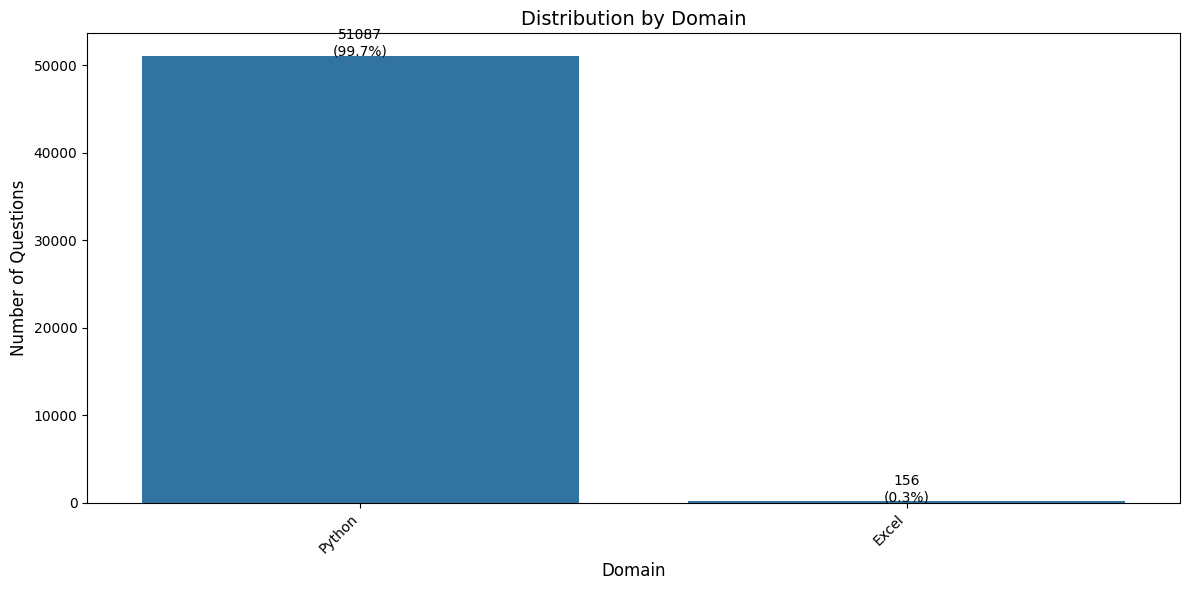

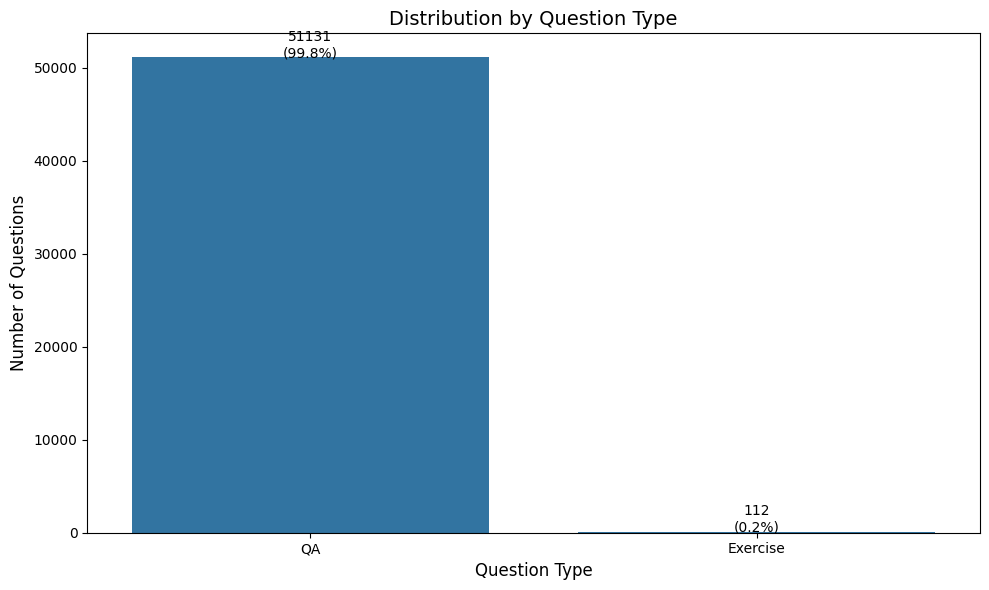

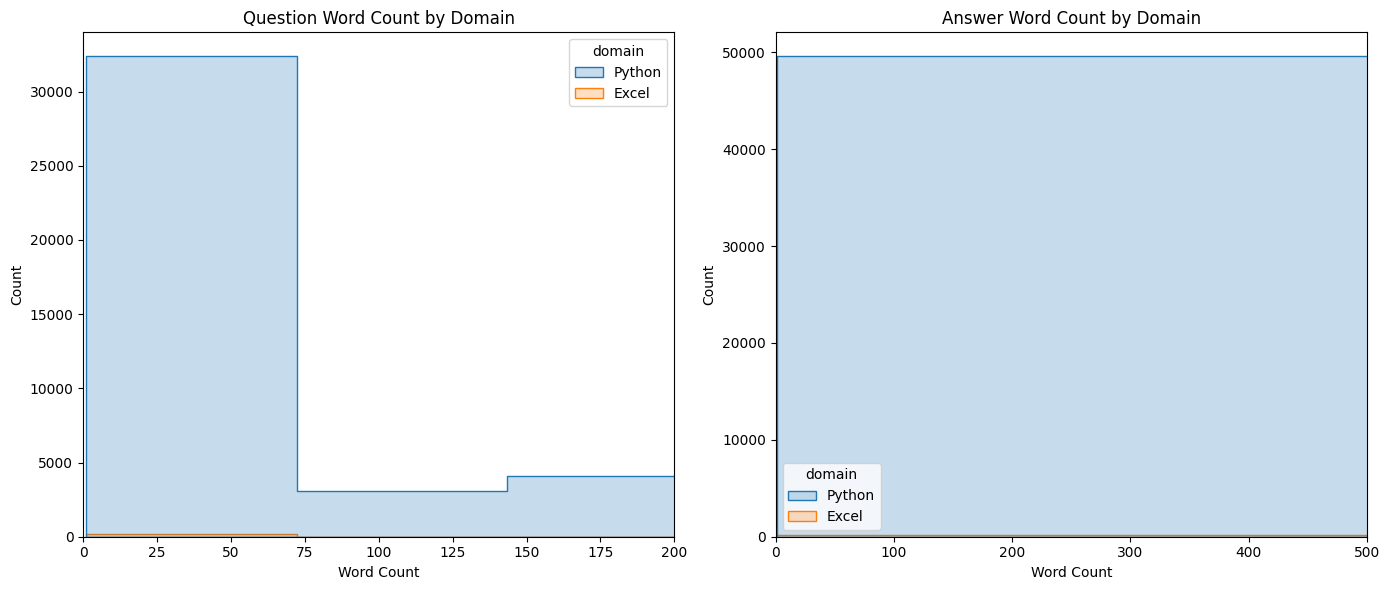

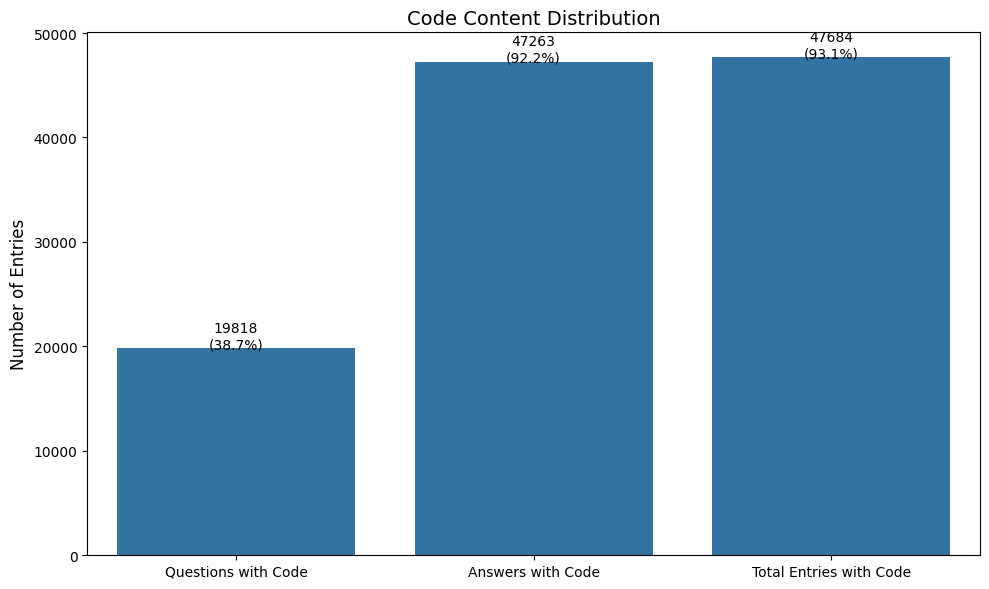

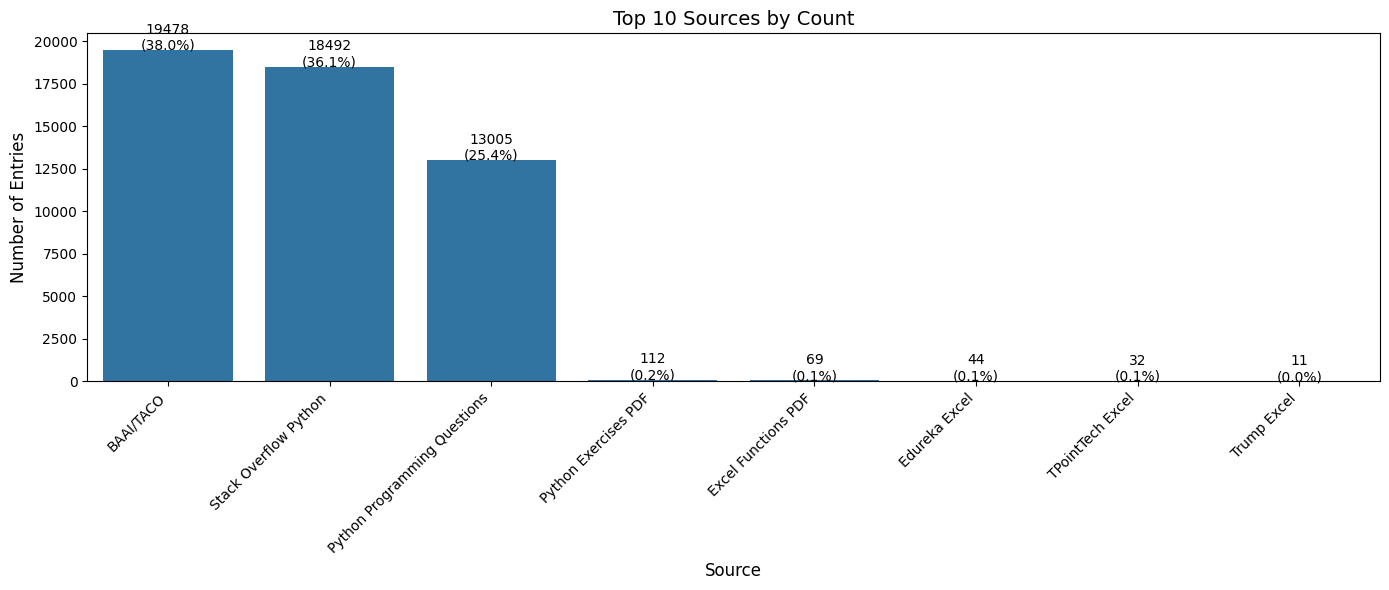

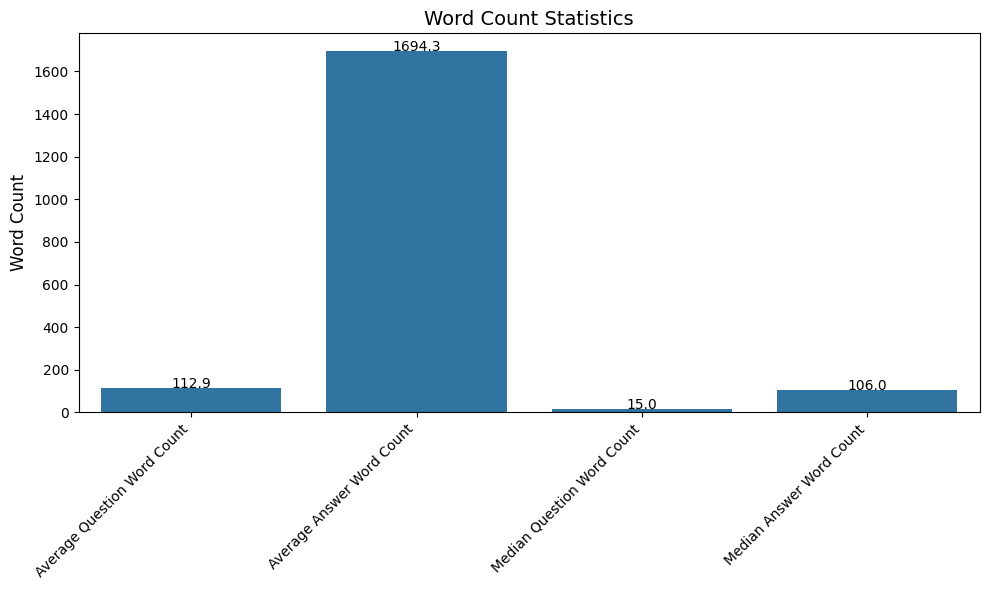


Data visualization complete!


In [ ]:
# 12: Data Visualization and Export
# --------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

print("Creating visualizations...")

# 1. Domain distribution
plt.figure(figsize=(12, 6))
domain_counts = cleaned_df['domain'].value_counts()
sns.barplot(x=domain_counts.index, y=domain_counts.values)
plt.title('Distribution by Domain', fontsize=14)
plt.ylabel('Number of Questions', fontsize=12)
plt.xlabel('Domain', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, count in enumerate(domain_counts.values):
    plt.text(i, count + 5, f"{count}\n({count/sum(domain_counts.values)*100:.1f}%)",
             ha='center', fontsize=10)
plt.tight_layout()
display(plt.gcf())  # Display the current figure
plt.close()

# 2. Question type distribution
plt.figure(figsize=(10, 6))
type_counts = cleaned_df['type'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('Distribution by Question Type', fontsize=14)
plt.ylabel('Number of Questions', fontsize=12)
plt.xlabel('Question Type', fontsize=12)
for i, count in enumerate(type_counts.values):
    plt.text(i, count + 5, f"{count}\n({count/sum(type_counts.values)*100:.1f}%)",
             ha='center', fontsize=10)
plt.tight_layout()
display(plt.gcf())  # Display the current figure
plt.close()

# 3. Question and answer length distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=cleaned_df, x='question_word_count', hue='domain',
             element='step', bins=30, log_scale=False, common_norm=False)
plt.title('Question Word Count by Domain')
plt.xlabel('Word Count')
plt.xlim(0, 200)  # Focus on typical question lengths
plt.subplot(1, 2, 2)
sns.histplot(data=cleaned_df, x='answer_word_count', hue='domain',
             element='step', bins=30, log_scale=False, common_norm=False)
plt.title('Answer Word Count by Domain')
plt.xlabel('Word Count')
plt.xlim(0, 500)  # Focus on typical answer lengths
plt.tight_layout()
display(plt.gcf())  # Display the current figure
plt.close()

# 4. Code content distribution
plt.figure(figsize=(10, 6))
code_data = [
    cleaned_df['contains_code_q'].sum(),
    cleaned_df['contains_code_a'].sum(),
    cleaned_df['contains_code'].sum()
]
code_labels = ['Questions with Code', 'Answers with Code', 'Total Entries with Code']
sns.barplot(x=code_labels, y=code_data)
plt.title('Code Content Distribution', fontsize=14)
plt.ylabel('Number of Entries', fontsize=12)
for i, count in enumerate(code_data):
    plt.text(i, count + 5, f"{count}\n({count/len(cleaned_df)*100:.1f}%)",
             ha='center', fontsize=10)
plt.tight_layout()
display(plt.gcf())  # Display the current figure
plt.close()

# 5. Source distribution
plt.figure(figsize=(14, 6))
source_counts = cleaned_df['source'].value_counts().head(10)
sns.barplot(x=source_counts.index, y=source_counts.values)
plt.title('Top 10 Sources by Count', fontsize=14)
plt.ylabel('Number of Entries', fontsize=12)
plt.xlabel('Source', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, count in enumerate(source_counts.values):
    plt.text(i, count + 5, f"{count}\n({count/len(cleaned_df)*100:.1f}%)",
             ha='center', fontsize=10)
plt.tight_layout()
display(plt.gcf())  # Display the current figure
plt.close()

# 6. Word count comparison
plt.figure(figsize=(10, 6))
word_count_data = {
    'Average Question Word Count': cleaned_df['question_word_count'].mean(),
    'Average Answer Word Count': cleaned_df['answer_word_count'].mean(),
    'Median Question Word Count': cleaned_df['question_word_count'].median(),
    'Median Answer Word Count': cleaned_df['answer_word_count'].median()
}
sns.barplot(x=list(word_count_data.keys()), y=list(word_count_data.values()))
plt.title('Word Count Statistics', fontsize=14)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, value in enumerate(word_count_data.values()):
    plt.text(i, value + 1, f"{value:.1f}", ha='center', fontsize=10)
plt.tight_layout()
display(plt.gcf())  # Display the current figure
plt.close()

print("\nData visualization complete!")

In [ ]:
# Saving domain data preprocessed seperately

# Create domain-specific datasets
print("\nCreating domain-specific datasets:")
domains = cleaned_df['domain'].unique()
for domain in domains:
    domain_df = cleaned_df[cleaned_df['domain'] == domain]
    # Replace any spaces or special characters in domain name for the filename
    domain_filename = domain.replace(' ', '_').replace('/', '_')
    domain_df.to_csv(f'./output/{domain_filename}_dataset.csv', index=False)
    print(f"- Saved {domain} dataset with {len(domain_df)} entries")

# Create type-specific datasets
print("\nCreating question type-specific datasets:")
types = cleaned_df['type'].unique()
for qtype in types:
    type_df = cleaned_df[cleaned_df['type'] == qtype]
    type_df.to_csv(f'./output/{qtype}_questions_dataset.csv', index=False)
    print(f"- Saved {qtype} questions dataset with {len(type_df)} entries")


Creating domain-specific datasets:
- Saved Python dataset with 51087 entries
- Saved Excel dataset with 156 entries

Creating question type-specific datasets:
- Saved QA questions dataset with 51131 entries
- Saved Exercise questions dataset with 112 entries


Performing data quality assessment...

DATA QUALITY ASSESSMENT REPORT

DATA QUALITY ASSESSMENT REPORT

1. DATASET OVERVIEW
--------------------------------------------------
Total entries: 51243

2. DOMAIN DISTRIBUTION
--------------------------------------------------
Python: 51087 entries (99.7%)
Excel: 156 entries (0.3%)

3. QUESTION TYPE DISTRIBUTION
--------------------------------------------------
QA: 51131 entries (99.8%)
Exercise: 112 entries (0.2%)

4. TEXT STATISTICS BY DOMAIN
--------------------------------------------------

Python Statistics:
  - Number of entries: 51087
  - Average question length: 615.4 characters
  - Average answer length: 13880.7 characters
  - Average question words: 113.2
  - Average answer words: 1698.7

Excel Statistics:
  - Number of entries: 156
  - Average question length: 54.1 characters
  - Average answer length: 1618.4 characters
  - Average question words: 9.6
  - Average answer words: 250.8

5. TEXT STATISTICS BY QUESTION TYPE
-----------

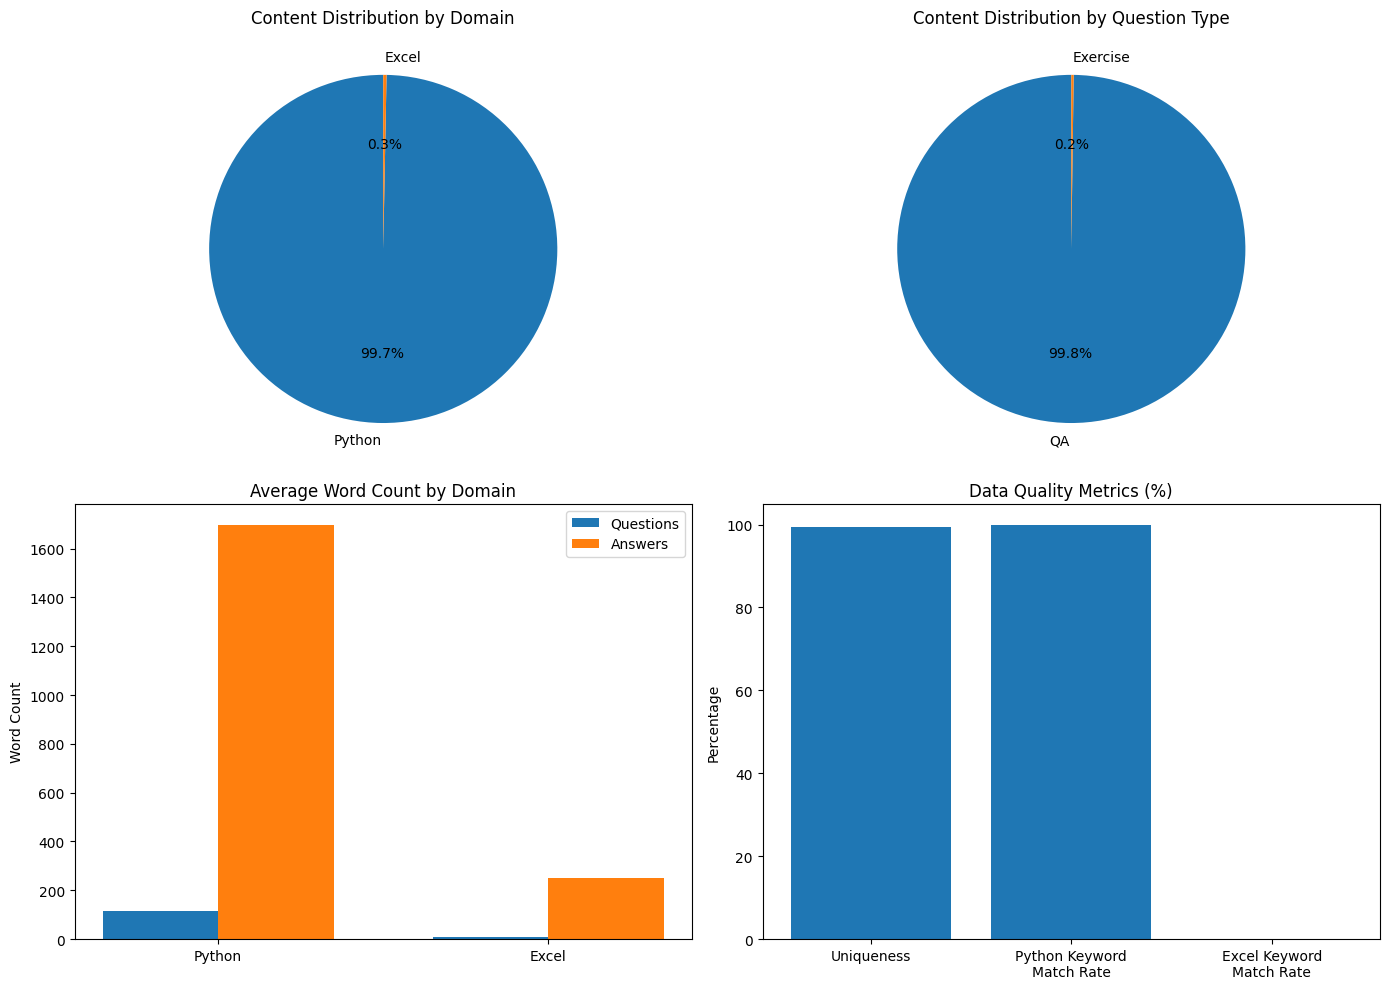

In [ ]:
# 13: Data Quality Assessment
# --------------------------------------------------------
print("Performing data quality assessment...")

# Create report directory if it doesn't exist
os.makedirs('./output/report', exist_ok=True)

# 1. Sample data for EDA
sample_size = min(5000, len(cleaned_df))
sample_df = cleaned_df.sample(sample_size, random_state=42)

# 2. Create comprehensive EDA report
report_content = ""

# Dataset overview
report_content += "DATA QUALITY ASSESSMENT REPORT\n"
report_content += "="*50 + "\n\n"

report_content += "1. DATASET OVERVIEW\n"
report_content += "-"*50 + "\n"
report_content += f"Total entries: {len(cleaned_df)}\n"

# Domain distribution
report_content += "\n2. DOMAIN DISTRIBUTION\n"
report_content += "-"*50 + "\n"
domain_counts = cleaned_df['domain'].value_counts()
for domain, count in domain_counts.items():
    report_content += f"{domain}: {count} entries ({count/len(cleaned_df)*100:.1f}%)\n"

# Question type distribution
report_content += "\n3. QUESTION TYPE DISTRIBUTION\n"
report_content += "-"*50 + "\n"
type_counts = cleaned_df['type'].value_counts()
for qtype, count in type_counts.items():
    report_content += f"{qtype}: {count} entries ({count/len(cleaned_df)*100:.1f}%)\n"

# Text statistics by domain
report_content += "\n4. TEXT STATISTICS BY DOMAIN\n"
report_content += "-"*50 + "\n"
for domain in cleaned_df['domain'].unique():
    domain_df = cleaned_df[cleaned_df['domain'] == domain]
    report_content += f"\n{domain} Statistics:\n"
    report_content += f"  - Number of entries: {len(domain_df)}\n"
    report_content += f"  - Average question length: {domain_df['question_length'].mean():.1f} characters\n"
    report_content += f"  - Average answer length: {domain_df['answer_length'].mean():.1f} characters\n"
    report_content += f"  - Average question words: {domain_df['question_word_count'].mean():.1f}\n"
    report_content += f"  - Average answer words: {domain_df['answer_word_count'].mean():.1f}\n"

# Text statistics by question type
report_content += "\n5. TEXT STATISTICS BY QUESTION TYPE\n"
report_content += "-"*50 + "\n"
for qtype in cleaned_df['type'].unique():
    type_df = cleaned_df[cleaned_df['type'] == qtype]
    report_content += f"\n{qtype} Statistics:\n"
    report_content += f"  - Number of entries: {len(type_df)}\n"
    report_content += f"  - Average question length: {type_df['question_length'].mean():.1f} characters\n"
    report_content += f"  - Average answer length: {type_df['answer_length'].mean():.1f} characters\n"
    report_content += f"  - Average question words: {type_df['question_word_count'].mean():.1f}\n"
    report_content += f"  - Average answer words: {type_df['answer_word_count'].mean():.1f}\n"

# Most common words in questions
from collections import Counter
report_content += "\n6. CONTENT ANALYSIS\n"
report_content += "-"*50 + "\n"

for domain in sample_df['domain'].unique():
    domain_sample = sample_df[sample_df['domain'] == domain]

    # Get most common words in processed questions
    all_words = ' '.join(domain_sample['processed_question'].fillna('').astype(str)).split()
    word_counts = Counter(all_words).most_common(20)

    report_content += f"\nMost common words in {domain} questions:\n"
    for word, count in word_counts:
        if len(word) > 2:  # Skip very short words
            report_content += f"  - {word}: {count} occurrences\n"

# Data quality metrics
report_content += "\n7. DATA QUALITY METRICS\n"
report_content += "-"*50 + "\n"

# Calculate missing values
missing_questions = cleaned_df['question'].isna().sum()
missing_answers = cleaned_df['answer'].isna().sum()
report_content += f"Missing questions: {missing_questions} ({missing_questions/len(cleaned_df)*100:.2f}%)\n"
report_content += f"Missing answers: {missing_answers} ({missing_answers/len(cleaned_df)*100:.2f}%)\n"

# Calculate duplicate rate
total_entries = len(cleaned_df)
unique_questions = len(cleaned_df['question'].unique())
duplicate_rate = 100 * (1 - unique_questions / total_entries)
report_content += f"Question uniqueness: {unique_questions} unique out of {total_entries} total ({duplicate_rate:.2f}% duplicate rate)\n"

# Domain content verification
report_content += "\n8. DOMAIN CONTENT VERIFICATION\n"
report_content += "-"*50 + "\n"

# Define domain-specific keywords
domain_keywords = {
    'Python': ['python', 'function', 'class', 'import', 'def', 'list', 'dictionary', 'tuple'],
    'Excel': ['excel', 'spreadsheet', 'cell', 'formula', 'vlookup', 'pivot', 'worksheet', 'column']
}

# Filter for just Python and Excel domains
for domain in ['Python', 'Excel']:
    if domain in sample_df['domain'].unique():
        domain_sample = sample_df[sample_df['domain'] == domain].sample(min(100, len(sample_df[sample_df['domain'] == domain])))

        if domain in domain_keywords:
            keywords = domain_keywords[domain]

            keyword_matches = 0
            total_entries = len(domain_sample)

            for _, row in domain_sample.iterrows():
                text = (str(row['question']) + ' ' + str(row['answer'])).lower()
                if any(keyword in text for keyword in keywords):
                    keyword_matches += 1

            match_rate = keyword_matches / total_entries if total_entries > 0 else 0
            report_content += f"{domain} keyword match rate: {match_rate:.1%}\n"

# Conclusion
report_content += "\n9. CONCLUSION\n"
report_content += "-"*50 + "\n"
report_content += "The dataset contains a comprehensive collection of Python and Excel questions and answers.\n"

# Specific notes on data quality
python_percent = len(cleaned_df[cleaned_df['domain'] == 'Python'])/len(cleaned_df)*100 if 'Python' in cleaned_df['domain'].unique() else 0
excel_percent = len(cleaned_df[cleaned_df['domain'] == 'Excel'])/len(cleaned_df)*100 if 'Excel' in cleaned_df['domain'].unique() else 0

report_content += f"Python content represents {python_percent:.1f}% of the dataset.\n"
report_content += f"Excel content represents {excel_percent:.1f}% of the dataset.\n"

# Assessment of question types
qa_percent = len(cleaned_df[cleaned_df['type'] == 'QA'])/len(cleaned_df)*100 if 'QA' in cleaned_df['type'].unique() else 0
mcq_percent = len(cleaned_df[cleaned_df['type'] == 'MCQ'])/len(cleaned_df)*100 if 'MCQ' in cleaned_df['type'].unique() else 0
exercise_percent = len(cleaned_df[cleaned_df['type'] == 'Exercise'])/len(cleaned_df)*100 if 'Exercise' in cleaned_df['type'].unique() else 0

report_content += f"Question-Answer pairs represent {qa_percent:.1f}% of the dataset.\n"
report_content += f"Multiple Choice Questions represent {mcq_percent:.1f}% of the dataset.\n"
report_content += f"Programming Exercises represent {exercise_percent:.1f}% of the dataset.\n"

report_content += "\nThe dataset is ready for use in training the AI Mock Interviewer system for Data Analytics/Science.\n"

# Save report to file
with open('./output/report/data_quality_assessment.txt', 'w') as f:
    f.write(report_content)

# Display report in output cell
print("\n" + "="*80)
print("DATA QUALITY ASSESSMENT REPORT")
print("="*80 + "\n")
print(report_content)

print("\nData quality assessment complete - report saved to './output/report/data_quality_assessment.txt'")

# Create visual summary of key metrics
plt.figure(figsize=(14, 10))

# Domain distribution pie chart
plt.subplot(2, 2, 1)
plt.pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Content Distribution by Domain')

# Question type distribution pie chart
plt.subplot(2, 2, 2)
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Content Distribution by Question Type')

# Text length distribution by domain
plt.subplot(2, 2, 3)
domain_avg_q_length = [cleaned_df[cleaned_df['domain'] == domain]['question_word_count'].mean()
                      for domain in domain_counts.index]
domain_avg_a_length = [cleaned_df[cleaned_df['domain'] == domain]['answer_word_count'].mean()
                      for domain in domain_counts.index]

x = np.arange(len(domain_counts.index))
width = 0.35

plt.bar(x - width/2, domain_avg_q_length, width, label='Questions')
plt.bar(x + width/2, domain_avg_a_length, width, label='Answers')
plt.xticks(x, domain_counts.index)
plt.title('Average Word Count by Domain')
plt.ylabel('Word Count')
plt.legend()

# Data quality metrics
plt.subplot(2, 2, 4)
quality_metrics = {
    'Uniqueness': 100 - duplicate_rate,
    'Python Keyword\nMatch Rate': (next((match_rate for domain, match_rate in locals().items()
                                       if domain.startswith('match_rate')), 0) * 100),
    'Excel Keyword\nMatch Rate': (next((match_rate for domain, match_rate in locals().items()
                                      if domain != 'match_rate' and 'match_rate' in domain), 0) * 100)
}
plt.bar(quality_metrics.keys(), quality_metrics.values())
plt.title('Data Quality Metrics (%)')
plt.ylabel('Percentage')

plt.tight_layout()
display(plt.gcf())
plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')